**W207 MultiModal Learning for Emotion Recognition: Audio Feature + Video Feature**

In [1]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from keras import backend as K
from keras.utils import np_utils
from matplotlib import pyplot as plt
from keras.constraints import maxnorm
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D, AveragePooling2D, Concatenate,ConvLSTM2D
from sklearn.model_selection import cross_val_score
import keras
import sklearn
import matplotlib


print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)
print(matplotlib.__version__)


1.23.5
1.5.3
0.12.2
2.10.1
2.10.0
1.2.0
3.6.3


**Dataset Import and Dataframe Convert**

In [2]:
# === Dataset Path
dataset_path = "F:/Coding Projects/Data_Spell_Workspace/project_w207_video_process/Dataset/Process_4_MultiModal/audio_and_video.npy"
# === Import processed_data
source_data = np.load(dataset_path,allow_pickle=True)
# === print download
print("Dataset Loading Completed")
# === Convert NPY into Dataframes and print head(5)
df = pd.DataFrame(columns=["speaker","mfcc","mfcc_delta","video","augmented","emotion","path"])
for i in range(0,len(source_data)):
    df.loc[len(df)+1] = [source_data[i][0], source_data[i][1], source_data[i][2], source_data[i][3],source_data[i][4],source_data[i][5],source_data[i][6]]
label_dict = {"a":0,"n":1,"su":2,"sa":3,"d":4,"h":5,"f":6}
df["label_value"] = df["emotion"].replace(label_dict)
print("DataFrame Converted")

Dataset Loading Completed
DataFrame Converted


**Resizing Audio Features**

In [3]:
# Function: Get Maximum Size
def max_size(data):
    max_row_size = 0
    max_column_size = 0

    # Iterate through the Series to find the maximum row and column sizes
    for array in data:
        row_size, column_size = array.shape
        max_row_size = max(max_row_size, row_size)
        max_column_size = max(max_column_size, column_size)
    return max_row_size, max_column_size
# Function: Resizing the params
def resize(x):
    return np.pad(x, pad_width=((0, max_row_size - x.shape[0]),
                                (0, max_column_size - x.shape[1])),
                  mode='constant')

# === Resizing MFCC
max_row_size, max_column_size = max_size(df['mfcc'])
print(max_row_size, max_column_size)
df['mfcc'] = df['mfcc'].apply(resize)
max_row_size, max_column_size = max_size(df['mfcc_delta'])
print(max_row_size, max_column_size)
df['mfcc_delta'] = df['mfcc_delta'].apply(resize)

40 290
40 290


**Function: Tensor Convert**

In [4]:
def train_test_processing(train_x_video,test_x_video,train_x_mfcc,test_x_mfcc,train_x_mfcc_delta,test_x_mfcc_delta,train_y,test_y):
    # === Convert df.columns into list
    train_x_video = [i for i in train_x_video]
    test_x_video = [i for i in test_x_video]
    train_x_mfcc = [i for i in train_x_mfcc]
    test_x_mfcc = [i for i in test_x_mfcc]
    train_x_mfcc_delta = [i for i in train_x_mfcc_delta]
    test_x_mfcc_delta = [i for i in test_x_mfcc_delta]
    train_y = [i for i in train_y]
    test_y = [i for i in test_y]

    # === Convert list into arrays
    train_x_video = np.array(train_x_video)
    test_x_video = np.array(test_x_video)
    train_x_mfcc = np.array(train_x_mfcc)
    test_x_mfcc = np.array(test_x_mfcc)
    train_x_mfcc_delta = np.array(train_x_mfcc_delta)
    test_x_mfcc_delta = np.array(test_x_mfcc_delta)
    train_y = np.array(train_y)
    test_y = np.array(test_y)


    # === Tensor Convert
    train_x_video = K.cast_to_floatx(train_x_video)
    test_x_video = K.cast_to_floatx(test_x_video)
    train_y = K.cast_to_floatx(train_y)
    test_y = K.cast_to_floatx(test_y)
    # Copy label list
    confusion_test_y = test_y
    class_weight_y = train_y

    # === Normalization
    train_x_video = train_x_video.astype('float32')
    test_x_video = test_x_video.astype('float32')
    train_x_video = train_x_video / 255.0
    test_x_video = test_x_video / 255.0
    train_x_mfcc = train_x_mfcc / 255.0
    test_x_mfcc = test_x_mfcc / 255.0
    train_x_mfcc_delta = train_x_mfcc_delta / 255.0
    test_x_mfcc_delta = test_x_mfcc_delta / 255.0

    # === One-hot Encoding
    train_y = np_utils.to_categorical(train_y)
    test_y = np_utils.to_categorical(test_y)
    class_num = test_y.shape[1]

    # === print result
    print("train_x_video: ", len(train_x_video))
    print("test_x_video: ", len(test_x_video))
    print("train_x_mfcc: ", len(train_x_mfcc))
    print("test_x_mfcc: ", len(test_x_mfcc))
    print("train_x_mfcc_delta: ", len(train_x_mfcc_delta))
    print("test_x_mfcc_delta: ", len(test_x_mfcc_delta))
    print("train_y: ", len(train_y))
    print("test_y: ", len(test_y))
    return train_x_video,test_x_video,train_x_mfcc,test_x_mfcc,train_x_mfcc_delta,test_x_mfcc_delta,train_y,test_y,confusion_test_y,class_weight_y

**Function: MultiModal Fusion Model Architecture**

In [5]:
# === Function: Model Construction
def build_model(n_classes, video_train, audio_train, optimizer, learning_rate):

    # === Initial model and set seed
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)


    # === Input A: Videos
    # Input Layer
    video_input = Input((6,64,64,3))
    # Layer 1: Convolutional LSTM Layer
    video_part = ConvLSTM2D(filters=32, kernel_size=(5, 5),input_shape = (6,64,64,3),activation='relu')(video_input)
    video_part = BatchNormalization()(video_part)
    # Layer 2: Convolutional Layer
    video_part = Conv2D(32, (3, 3),activation='relu')(video_part)
    video_part = MaxPool2D(2,2)(video_part)
    video_part = Dropout(0.2)(video_part)
    video_part = BatchNormalization()(video_part)
    # Flatten Layer
    video_part = Flatten()(video_part)
    # video_part = Dropout(0.2)(video_part)
    # Dense Layer
    video_part = Dense(16, kernel_constraint=maxnorm(3), kernel_regularizer=regularizers.l2(0.01),activation='relu')(video_part)
    # video_part = Dropout(0.2)(video_part)
    video_part = BatchNormalization()(video_part)


    # === Input B: Audios
    # Input Lauyer
    audio_input = Input((40, 290, 1))
    # Layer 1: Convolutional Layer
    audio_part = Conv2D(32, (5,5),activation='relu')(audio_input)
    audio_part = AveragePooling2D(3,3)(audio_part)
    audio_part = Dropout(0.2)(audio_part)
    audio_part = BatchNormalization()(audio_part)
    # Layer 2: Convolutional Layer
    audio_part = Conv2D(16, (3,3),activation='relu')(audio_part)
    audio_part = BatchNormalization()(audio_part)
    audio_part = MaxPool2D(2,2)(audio_part)
    # Flatten Layer
    audio_part = Flatten()(audio_part)
    # audio_part = Dropout(0.2)(audio_part)
    # Dense Layer
    audio_part = Dense(32, activation='relu')(audio_part)


    # === MultiModal: Video + Audio
    # Concatenation Layer
    Multimodal = Concatenate()([video_part, audio_part])
    # Layer 1: Dense Layer
    Multimodal = Dense(units=32, activation='relu')(Multimodal)
    Multimodal = Dropout(0.2)(Multimodal)
    Multimodal = BatchNormalization()(Multimodal)
    # Layer 2: Dense Layer
    Multimodal = Dense(units=32, activation='relu')(Multimodal)
    # Multimodal = Dropout(0.2)(Multimodal)
    Multimodal = BatchNormalization()(Multimodal)
    # Output Layer with Softmax
    output = Dense(units=n_classes, activation='softmax')(Multimodal)

    # Run Model
    model = Model(inputs=[video_input, audio_input], outputs=output)

    # Optimizers
    if optimizer == "SGD":
        model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      metrics=['accuracy'])
    elif optimizer == "Adam":
        model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      metrics=['accuracy'])

    # print model Architecture
    print(model.summary())

    # Return model result
    return model

**Function: Accuracy & Loss Diagram**

In [6]:
def Acc_Loss_diagram(counter):
    # === Summarize history for accuracy
    plt.plot(history.history['accuracy'],c ="darkcyan")
    plt.plot(history.history['val_accuracy'])
    plt.title('MultiModal - Accuracy Diagram CV' + str(counter))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(ls = "--", lw = 0.5, color = "#4E616C")
    plt.show()
    # === Summarize history for loss
    plt.plot(history.history['loss'],c ="darkcyan")
    plt.plot(history.history['val_loss'])
    plt.title('MultiModal - Loss Diagram CV' + str(counter))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(ls = "--", lw = 0.5, color = "#4E616C")
    plt.show()

**Cross Validation Model Training**

------------------ Cross Validation Training ------------------  1
train_x_video:  1440
test_x_video:  480
train_x_mfcc:  1440
test_x_mfcc:  480
train_x_mfcc_delta:  1440
test_x_mfcc_delta:  480
train_y:  1440
test_y:  480
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40, 290, 1)  0           []                               
                                ]                                                                 
                                                                     

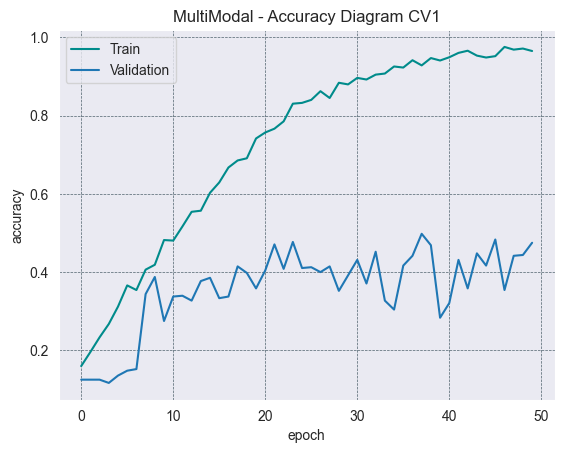

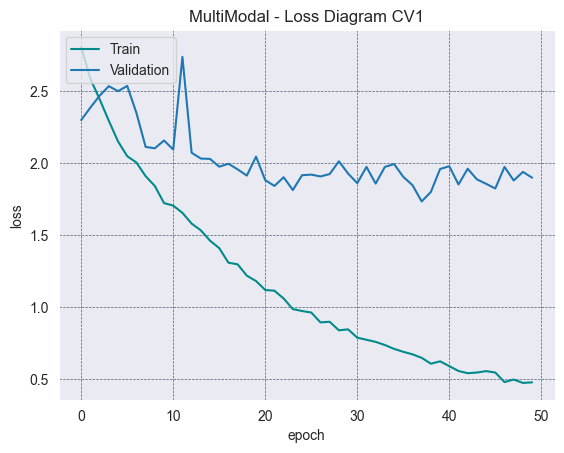

15/15 [==============================] - 1s 20ms/step
------------------ Cross Validation Training ------------------  2
train_x_video:  1440
test_x_video:  480
train_x_mfcc:  1440
test_x_mfcc:  480
train_x_mfcc_delta:  1440
test_x_mfcc_delta:  480
train_y:  1440
test_y:  480
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40, 290, 1)  0           []                               
                                ]                                                                 
               

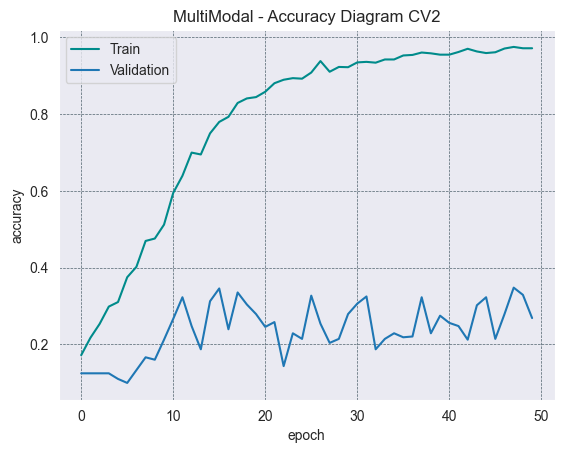

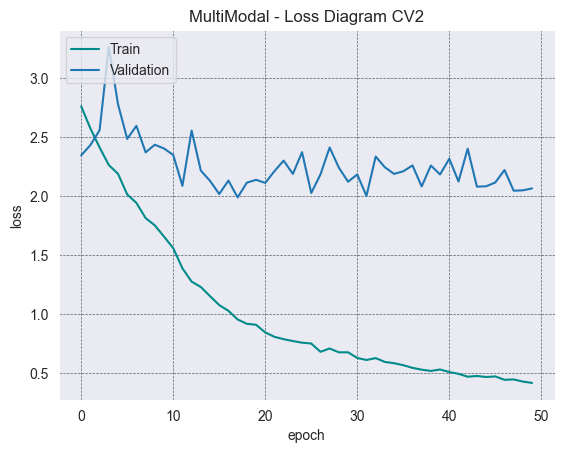

15/15 [==============================] - 1s 22ms/step
------------------ Cross Validation Training ------------------  3
train_x_video:  1440
test_x_video:  480
train_x_mfcc:  1440
test_x_mfcc:  480
train_x_mfcc_delta:  1440
test_x_mfcc_delta:  480
train_y:  1440
test_y:  480
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40, 290, 1)  0           []                               
                                ]                                                                 
               

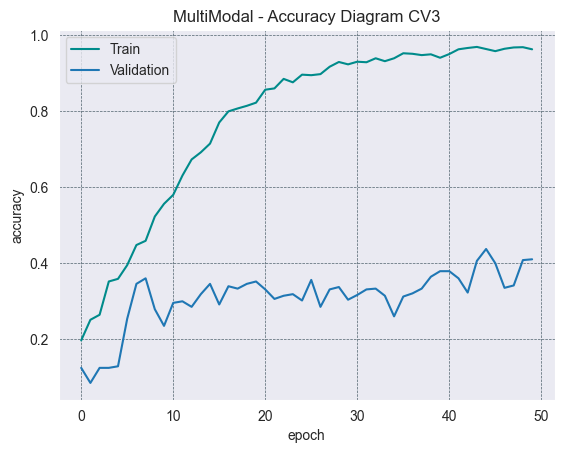

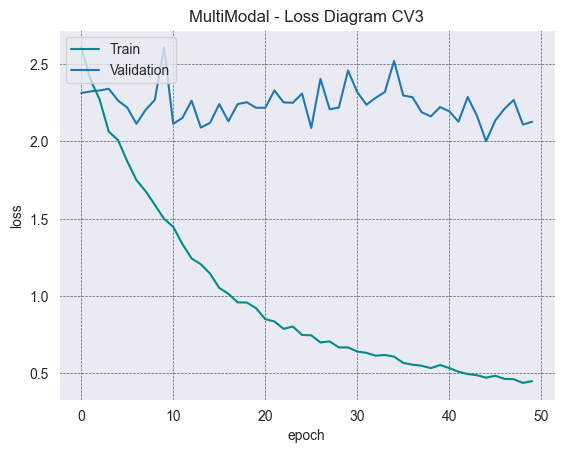

15/15 [==============================] - 1s 21ms/step
------------------ Cross Validation Training ------------------  4
train_x_video:  1440
test_x_video:  480
train_x_mfcc:  1440
test_x_mfcc:  480
train_x_mfcc_delta:  1440
test_x_mfcc_delta:  480
train_y:  1440
test_y:  480
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40, 290, 1)  0           []                               
                                ]                                                                 
               

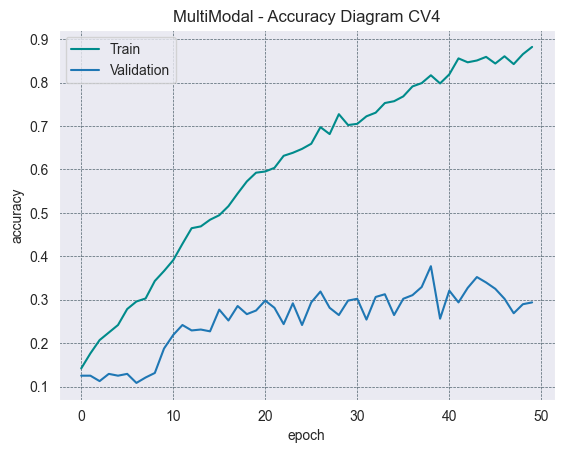

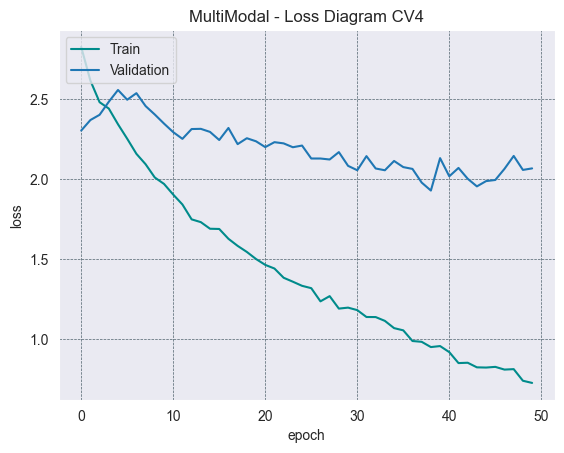

15/15 [==============================] - 1s 21ms/step


In [7]:
# Accuracy and Loss Save
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
# Prediction Save
test_y_dense= []
predict_y_total = []
test_y_one_hot = []
# counting Time
counter = 1

# === Group Stratified Dataset Train/Test Split
spliter = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=10)
for train_index, val_index in spliter.split(df.video, df.label_value, df.speaker):
    print("------------------ Cross Validation Training ------------------ ",counter)
    # Train / Test Split by Group
    train_x_video, test_x_video = df.video.iloc[train_index], df.video.iloc[val_index]
    train_x_mfcc, test_x_mfcc = df.mfcc.iloc[train_index], df.mfcc.iloc[val_index]
    train_x_mfcc_delta, test_x_mfcc_delta = df.mfcc_delta.iloc[train_index], df.mfcc_delta.iloc[val_index]
    # Labels Split
    train_y, test_y = df.label_value.iloc[train_index], df.label_value.iloc[val_index]

    # Train/Test Dataset Processing
    train_x_video,test_x_video,train_x_mfcc,test_x_mfcc,train_x_mfcc_delta,test_x_mfcc_delta,train_y,test_y,confusion_test_y,class_weight_y = train_test_processing(train_x_video,test_x_video,train_x_mfcc,test_x_mfcc,train_x_mfcc_delta,test_x_mfcc_delta,train_y,test_y)
    test_y_dense.append(confusion_test_y)
    test_y_one_hot.append(test_y)
    # === Balance weights for model training
    class_weights = class_weight.compute_class_weight(class_weight="balanced",classes=np.unique(class_weight_y),y = class_weight_y)
    class_weight_dict = dict(zip([x for x in np.unique(class_weight_y)], class_weights))
    # === Build the model
    model = build_model(n_classes=7, video_train = train_x_video, audio_train = train_x_mfcc, optimizer="Adam",learning_rate=0.00003)
    # === Train the model
    history = model.fit(x=[train_x_video, train_x_mfcc], y=train_y, class_weight=class_weight_dict, epochs=50, batch_size=20, validation_data=([test_x_video, test_x_mfcc], test_y))
    # Draw Accuracy and Loss
    Acc_Loss_diagram(counter)
    counter += 1
    predict_y_total.append(model.predict([test_x_video, test_x_mfcc]))
    # Append Score
    train_accuracy.append(history.history['accuracy'][-1])
    val_accuracy.append(history.history['val_accuracy'][-1])
    train_loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])

**Performance Evaluation: Cross Validation Accuracy and Loss**

In [8]:
# === Print Cross validation Result
print("----------- Cross Validation Detail Result -----------")
print("Training Accuracy: ",train_accuracy)
print("Validation Accuracy: ",val_accuracy)
print("Training Loss: ",train_loss)
print("Validation Loss: ",val_loss)
print("----------- Cross Validation Result -----------")
print('Cross Validation Training Accuracy: %.3f +/- %.3f' % (np.mean(train_accuracy),np.std(train_accuracy)))
print('Cross Validation Validation Accuracy: %.3f +/- %.3f' % (np.mean(val_accuracy),np.std(val_accuracy)))
print('Cross Validation Training Loss: %.3f +/- %.3f' % (np.mean(train_loss),np.std(train_loss)))
print('Cross Validation Validation Loss: %.3f +/- %.3f' % (np.mean(val_loss),np.std(val_loss)))

----------- Cross Validation Detail Result -----------
Training Accuracy:  [0.9652777910232544, 0.9708333611488342, 0.9624999761581421, 0.8819444179534912]
Validation Accuracy:  [0.4749999940395355, 0.26875001192092896, 0.4104166626930237, 0.29374998807907104]
Training Loss:  [0.47817984223365784, 0.41371047496795654, 0.4502555727958679, 0.727403998374939]
Validation Loss:  [1.8970210552215576, 2.0635881423950195, 2.1270368099212646, 2.0660653114318848]
----------- Cross Validation Result -----------
Cross Validation Training Accuracy: 0.945 +/- 0.037
Cross Validation Validation Accuracy: 0.362 +/- 0.084
Cross Validation Training Loss: 0.517 +/- 0.123
Cross Validation Validation Loss: 2.038 +/- 0.086


**Performance Evaluation: AUC ROC**

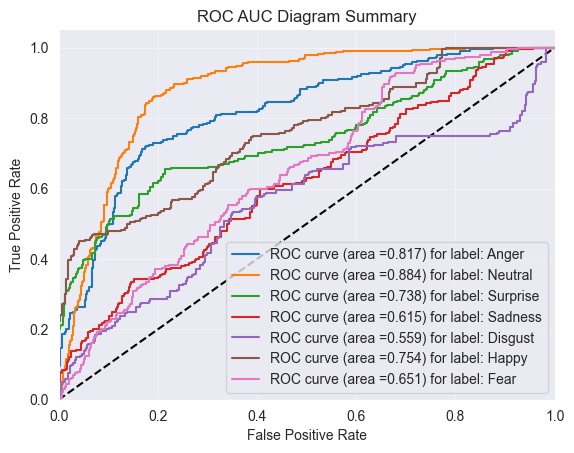

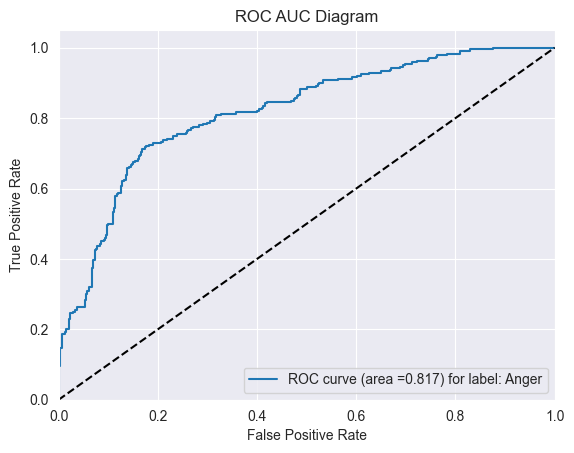

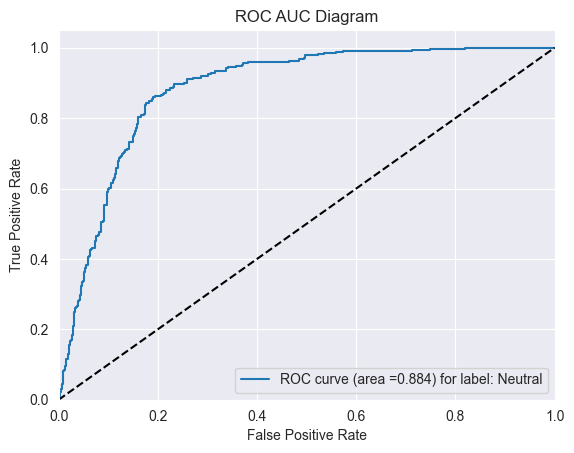

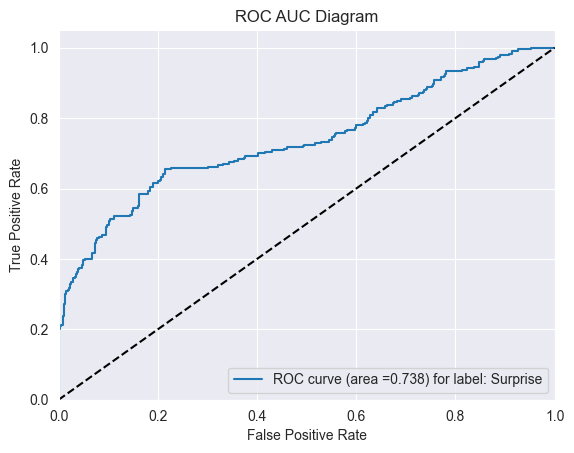

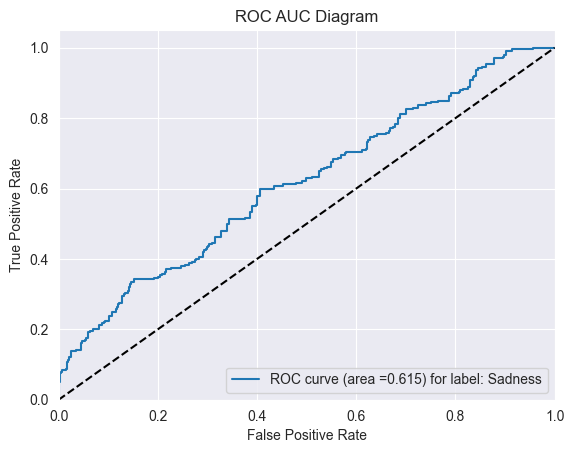

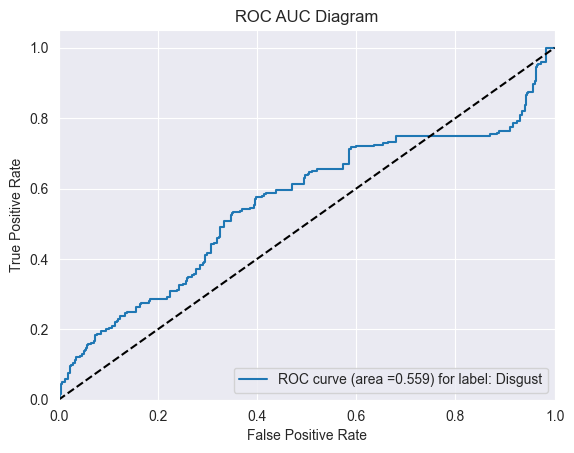

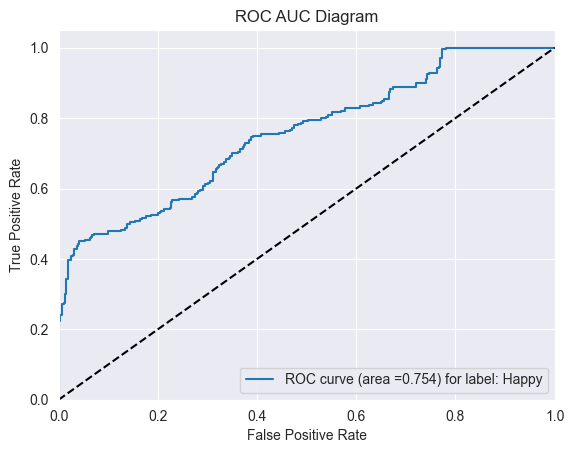

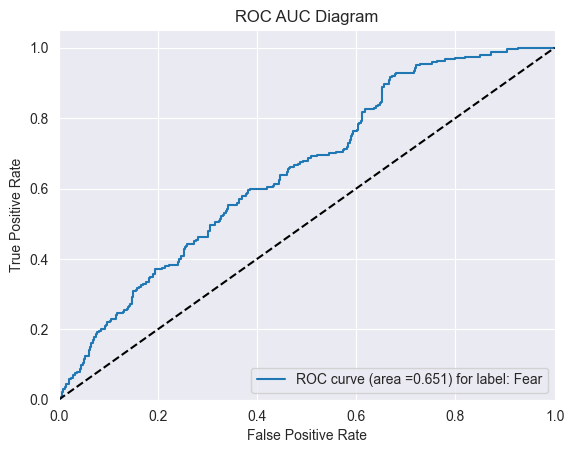

In [9]:
# === Concatenate values
convert_test_y_one_hot = np.concatenate((test_y_one_hot[0],test_y_one_hot[1],test_y_one_hot[2],test_y_one_hot[3]))
convert_predict_y_total = np.concatenate((predict_y_total[0],predict_y_total[1],predict_y_total[2],predict_y_total[3]))

# === Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(convert_test_y_one_hot[:, i], convert_predict_y_total[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

label_dict = {"Anger":0,"Neutral":1,"Surprise":2,"Sadness":3,"Disgust":4,"Happy":5,"Fear":6}
label_name = {v:k for k,v in label_dict.items()}
# Plot in one diagram
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC AUC Diagram Summary')
for i in range(7):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area ='+str(round(roc_auc[i],3))+') for label: '+label_name[i])
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()

# Plot AUC ROC individually
for i in range(7):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area ='+str(round(roc_auc[i],3))+') for label: '+label_name[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Diagram')
    plt.legend(loc="lower right")

**Performance Evaluation: Confusion Matrix & Classification Report**

              precision    recall  f1-score   support

         0.0       0.40      0.56      0.47       240
         1.0       0.68      0.41      0.51       480
         2.0       0.47      0.46      0.47       240
         3.0       0.19      0.25      0.21       240
         4.0       0.26      0.19      0.22       240
         5.0       0.26      0.56      0.36       240
         6.0       0.25      0.06      0.10       240

    accuracy                           0.36      1920
   macro avg       0.36      0.36      0.33      1920
weighted avg       0.40      0.36      0.36      1920



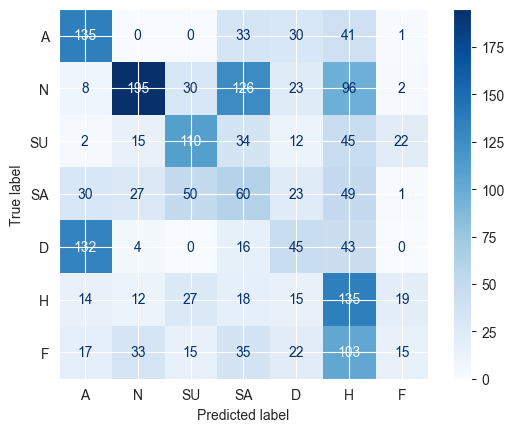

In [10]:
# === Concatenate values
convert_test_y_dense = np.concatenate((test_y_dense[0],test_y_dense[1],test_y_dense[2],test_y_dense[3]))
convert_y_test_pred = np.concatenate((predict_y_total[0],predict_y_total[1],predict_y_total[2],predict_y_total[3]))

#  === Print confusion matrix
# y_test_pred = model.predict([test_x_video, test_x_mfcc])
y_test_pred = np.argmax(convert_y_test_pred, axis=1)
# Classification Report
print(classification_report(convert_test_y_dense, y_test_pred))
# Confusiont Matrix
target_names = ["A","N","SU","SA","D","H","F"]
cm_display = ConfusionMatrixDisplay.from_predictions(convert_test_y_dense, y_test_pred, display_labels=target_names,cmap = 'Blues')